In [1]:
# Set full width on jupyter notebook navigator
from IPython.core.display import HTML, display

display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
# For dark mode only, font in white
import matplotlib as mpl
"""
mpl.rcParams.update(
    {"axes.labelcolor": "white", "xtick.color": "white", "ytick.color": "white"}
)""";

# Pipeline

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from tqdm import tqdm

In [4]:
dataset = pd.read_csv("./drinking_water_potability.csv")
dataset.head()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,NaN,204.890456,20791.31898,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.05786,6.635246,NaN,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.54173,9.275884,NaN,418.606213,16.868637,66.420093,3.055934,0
3,8.316766,214.373394,22018.41744,8.059332,356.886136,363.266516,18.436525,100.341674,4.628771,0
4,9.092223,181.101509,17978.98634,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0


In [5]:
train_set, test_set = train_test_split(
    dataset, train_size=0.75, random_state=42, stratify=dataset["Potability"]
)

target = "Potability"
feature_names = list(filter(lambda x: x != target, train_set.columns))

print(f"Elements in train: {train_set.shape[0]}")
print(f"Elements in test : {test_set.shape[0]}")
print(train_set["Potability"].value_counts() / train_set.shape[0])
print(test_set["Potability"].value_counts() / test_set.shape[0])

Elements in train: 2457
Elements in test : 819
0    0.610094
1    0.389906
Name: Potability, dtype: float64
0    0.60928
1    0.39072
Name: Potability, dtype: float64


## Removing the outliers before starting

In [6]:
from utils import process_remove_outliers_ph

processors = [process_remove_outliers_ph]

In [7]:
print("=" * 10, "TRAIN", "=" * 10)
print(f"Initial size: {train_set.shape}")
for processor in processors:
    train_set = processor(train_set)
    print(f"Apply {processor.__name__}, new size: {train_set.shape}")

print("\n" * 2, "=" * 10, "TEST", "=" * 10)
print(f"Initial size: {test_set.shape}")
for processor in processors:
    test_set = processor(test_set)
    print(f"Apply {processor.__name__}, new size: {test_set.shape}")

========== TRAIN ==========
Initial size: (2457, 10)
Apply process_remove_outliers_ph, new size: (2455, 10)


 ========== TEST ==========
Initial size: (819, 10)
Apply process_remove_outliers_ph, new size: (818, 10)


## All the transformers and steps of the pipeline

### Definition of the transformer pipeline

In [8]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

In [9]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

transformer = Pipeline(
    [
        ("Missing_values_handler", IterativeImputer(max_iter=10, random_state=0)),
        ("Scaler", StandardScaler()),
    ]
)
transformer

Pipeline(steps=[('Missing_values_handler', IterativeImputer(random_state=0)),
                ('Scaler', StandardScaler())])

## Models exploration

In [10]:
from sklearn.ensemble import (
    AdaBoostClassifier,
    ExtraTreesClassifier,
    GradientBoostingClassifier,
    RandomForestClassifier,
)

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    make_scorer,
    precision_score,
    recall_score,
)
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

models = [
    DecisionTreeClassifier(max_depth=7),
    LogisticRegression(),
    SVC(),
    KNeighborsClassifier(),
    GaussianNB(),
    RandomForestClassifier(),
    ExtraTreesClassifier(n_estimators=10),
    AdaBoostClassifier(),
    GradientBoostingClassifier(),
    GaussianNB(),
]

metrics = [accuracy_score, f1_score, precision_score, recall_score]
results = []

X_train, X_val, y_train, y_val = train_test_split(
    train_set[feature_names], train_set[target], train_size=0.8, random_state=20
)
for model in tqdm(models, desc="Training different models", unit="model"):
    scores = {"name": model.__class__.__name__}
    model = Pipeline([("transformer", transformer), ("model", model)])
    scores = {
        **scores,
        **{
            "cv_"
            + func.__name__: np.mean(
                cross_val_score(
                    model, X_train, y_train, cv=5, scoring=make_scorer(func)
                )
            )
            for func in metrics
        },
    }
    results.append(scores)
results_df = pd.DataFrame.from_records(results)

Training different models:  10%|█         | 1/10 [00:00<00:08,  1.09model/s]/home/marco/centralesupelec/ML/ML-Drinking_Water_Potability/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/marco/centralesupelec/ML/ML-Drinking_Water_Potability/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training different models: 100%|██████████| 10/10 [00:29<00:00,  2.91s/model]


In [12]:
results_df.sort_values(by=["cv_precision_score"], ascending=False)

,name,cv_accuracy_score,cv_f1_score,cv_precision_score,cv_recall_score
2,SVC,0.674646,0.405796,0.681204,0.290066
1,LogisticRegression,0.617107,0.007895,0.600000,0.003974
5,RandomForestClassifier,0.658342,0.421135,0.579625,0.333775
8,GradientBoostingClassifier,0.634941,0.330997,0.554913,0.237086
4,GaussianNB,0.625258,0.299515,0.532334,0.209272
9,GaussianNB,0.625258,0.299515,0.532334,0.209272
6,ExtraTreesClassifier,0.632902,0.330091,0.527141,0.296689
0,DecisionTreeClassifier,0.625750,0.346133,0.522737,0.263576
3,KNeighborsClassifier,0.606933,0.402819,0.483773,0.345695
7,AdaBoostClassifier,0.608967,0.321144,0.481623,0.242384


<AxesSubplot:xlabel='name'>

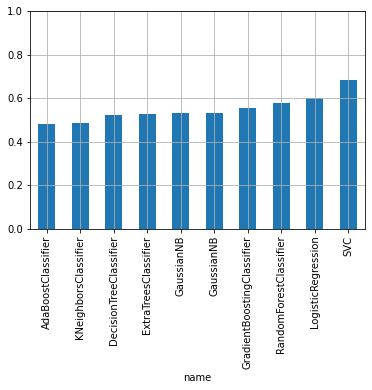

In [13]:
results_df.set_index("name")["cv_precision_score"].sort_values().plot.bar(
    ylim=[0, 1], grid=True
)

In [14]:
X_train, y_train = train_set[feature_names], train_set[target]
X_test, y_test = test_set[feature_names], test_set[target]

## Training

In [ ]:
from sklearn.model_selection import GridSearchCV

###  Grid search area

### SVC

In [ ]:
# Train using a grid search to find the best params
# For a SVC

param_grid = {
    "C": [0.1, 10, 50, 100],
    "kernel": ["linear", "poly", "sigmoid", "rbf"],
    "class_weight": [None, "balanced"],
}
param_grid = {"model__" + k: v for k, v in param_grid.items()}
pipeline_gs = Pipeline([("transformer", transformer), ("model", SVC())])
print(pipeline_gs.get_params())
grid_search = GridSearchCV(
    pipeline_gs,
    param_grid=param_grid,
    cv=5,
    verbose=10,
    n_jobs=-1,
    scoring=["f1_weighted", "accuracy", "average_precision"],
    refit=False,
)
grid_search.fit(X_train, y_train)

In [ ]:
_ = pd.DataFrame(grid_search.cv_results_)
_ = _.sort_values(by=["mean_test_average_precision"], ascending=False).reset_index(
    drop=True
)
_.head()

In [ ]:
print(_.loc[1])
print(_.at[1, "params"])

In [ ]:
print(
    """For the SVC, after Grid Search, we have the following:
mean_fit_time                                                             0.303844
std_fit_time                                                              0.021136
mean_score_time                                                           0.089625
std_score_time                                                             0.00434
param_model__C                                                                  10
param_model__class_weight                                                     None
param_model__kernel                                                            rbf
params                           {'model__C': 10, 'model__class_weight': None, ...
split0_test_f1_weighted                                                    0.69426
split1_test_f1_weighted                                                   0.626988
split2_test_f1_weighted                                                   0.647527
split3_test_f1_weighted                                                   0.635514
split4_test_f1_weighted                                                   0.643503
mean_test_f1_weighted                                                     0.649558
std_test_f1_weighted                                                      0.023434
rank_test_f1_weighted                                                            1
split0_test_accuracy                                                      0.700611
split1_test_accuracy                                                      0.643585
split2_test_accuracy                                                      0.663951
split3_test_accuracy                                                      0.651731
split4_test_accuracy                                                      0.659878
mean_test_accuracy                                                        0.663951
std_test_accuracy                                                          0.01962
rank_test_accuracy                                                               1
split0_test_average_precision                                             0.622592
split1_test_average_precision                                             0.579198
split2_test_average_precision                                             0.587247
split3_test_average_precision                                             0.571751
split4_test_average_precision                                             0.591173
mean_test_average_precision                                               0.590392
std_test_average_precision                                                0.017436
rank_test_average_precision                                                      2
Name: 1, dtype: object
{'model__C': 10, 'model__class_weight': None, 'model__kernel': 'rbf'}"""
)

### Random Forest

In [ ]:
# Train using a grid search to find the best params
# For a random forest

param_grid = {
    "n_estimators": [10, 50, 100, 150, 200, 250, 300],
    "max_features": list(range(2, len(X_train.columns) + 1)),
}
param_grid = {"model__" + k: v for k, v in param_grid.items()}
pipeline_gs = Pipeline(
    [("transformer", transformer), ("model", RandomForestClassifier())]
)
print(pipeline_gs.get_params())

grid_search = GridSearchCV(
    pipeline_gs,
    param_grid=param_grid,
    cv=5,
    verbose=10,
    n_jobs=-1,
    scoring=["f1_weighted", "accuracy", "average_precision"],
    refit=False,
)
grid_search.fit(X_train, y_train)

In [ ]:
_ = pd.DataFrame(grid_search.cv_results_)
print(_.columns)
_ = _.sort_values(by=["mean_test_average_precision"], ascending=False).reset_index(
    drop=True
)
_.head()

In [ ]:
IDX = 0
print(_.loc[IDX])
print(_.at[IDX, "params"])

In [ ]:
print(
    """mean_fit_time                                                             2.428444
std_fit_time                                                              0.049107
mean_score_time                                                           0.080467
std_score_time                                                            0.002905
param_model__max_features                                                        7
param_model__n_estimators                                                      250
params                           {'model__max_features': 7, 'model__n_estimator...
split0_test_f1_weighted                                                   0.672308
split1_test_f1_weighted                                                   0.673643
split2_test_f1_weighted                                                   0.646175
split3_test_f1_weighted                                                   0.611159
split4_test_f1_weighted                                                     0.6499
mean_test_f1_weighted                                                     0.650637
std_test_f1_weighted                                                      0.022706
rank_test_f1_weighted                                                            1
split0_test_accuracy                                                      0.687023
split1_test_accuracy                                                      0.694656
split2_test_accuracy                                                      0.671756
split3_test_accuracy                                                      0.653944
split4_test_accuracy                                                      0.673469
mean_test_accuracy                                                         0.67617
std_test_accuracy                                                         0.014002
rank_test_accuracy                                                               2
split0_test_average_precision                                             0.621502
split1_test_average_precision                                             0.576277
split2_test_average_precision                                             0.589649
split3_test_average_precision                                             0.592778
split4_test_average_precision                                             0.596943
mean_test_average_precision                                                0.59543
std_test_average_precision                                                 0.01476
rank_test_average_precision                                                      1
Name: 0, dtype: object
{'model__max_features': 7, 'model__n_estimators': 250}"""
)

In [ ]:
# Train using a grid search to find the best params
# For a gradientboosting model

param_grid = {
    "n_estimators": [10, 50, 100, 150, 200, 250, 300],
    "learning_rate": [1.0, 0.5, 5],
    "loss": ["deviance", "exponential"],
}
param_grid = {"model__" + k: v for k, v in param_grid.items()}
pipeline_gs = Pipeline(
    [("transformer", transformer), ("model", GradientBoostingClassifier())]
)
print(pipeline_gs.get_params())

grid_search = GridSearchCV(
    pipeline_gs,
    param_grid=param_grid,
    cv=5,
    verbose=10,
    n_jobs=-1,
    scoring=["f1_weighted", "accuracy", "average_precision"],
    refit=False,
)
grid_search.fit(X_train, y_train)

In [ ]:
_ = pd.DataFrame(grid_search.cv_results_)
print(_.columns)
_ = _.sort_values(by=["mean_test_average_precision"], ascending=False).reset_index(
    drop=True
)
_.head()

In [ ]:
IDX = 0
print(_.loc[IDX])
print(_.at[IDX, "params"])

### Final model training

In [ ]:
from sklearn.ensemble import VotingClassifier

In [ ]:
model = GradientBoostingClassifier(learning_rate=0.5, n_estimators=250)
model = SVC()
model = VotingClassifier(
    estimators=[
        ("svc", SVC()),
        ("gbc", GradientBoostingClassifier(learning_rate=0.5, n_estimators=100)),
        ("Random_forest", RandomForestClassifier(n_estimators=100, max_features=7)),
    ],
    voting="hard",
)
pipeline = Pipeline([("transformer", transformer), ("model", model)], verbose=True)

In [ ]:
pipeline.fit(X_train, y_train)

### Check on training set

In [ ]:
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    classification_report,
    confusion_matrix,
)

In [ ]:
y_train_pred = pipeline.predict(X_train)

print(classification_report(y_train, y_train_pred))

ConfusionMatrixDisplay(confusion_matrix(y_train, y_train_pred)).plot()

## Check on the test set

In [ ]:
y_test_pred = pipeline.predict(X_test)

print(classification_report(y_test, y_test_pred))

ConfusionMatrixDisplay(confusion_matrix(y_test, y_test_pred)).plot()